In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.patches as mpatches

# Merge excel files
path = "datasets/output/data_cleaned.xlsx"

dataset_df = pd.read_excel(path)

In [2]:
dataset_df = dataset_df[['CCAN', 'DATE', 'Status', 'TOT NET', 'Net Investment', '31-60', '61-90', '91-120', '120+', 'Past Due', 'Aging', 'Country']]

dataset_df.count()

CCAN              140236
DATE              140236
Status            140236
TOT NET           140236
Net Investment    140236
31-60             140236
61-90             140236
91-120            140236
120+              140236
Past Due          140236
Aging             140236
Country           140236
dtype: int64

In [3]:
# Count number of months as input
input_files = os.listdir("datasets/input/")
input_count = len(input_files)

# Create average per month past due and in millions per month
extended_dataset_df = dataset_df
extended_dataset_df["Past Due AVG MLN"] = round(extended_dataset_df["Past Due"] / input_count / 1000000, 2)
extended_dataset_df["Net Investment AVG MLN"] = round(extended_dataset_df["Net Investment"] / input_count / 1000000, 2)
extended_dataset_df["Year"] = pd.DatetimeIndex(extended_dataset_df['DATE']).year
extended_dataset_df["Past Due MLN"] = round(extended_dataset_df["Past Due"] / 1000000, 2)
extended_dataset_df["TOT NET MLN"] = round(extended_dataset_df["TOT NET"] / 1000000, 2)
extended_dataset_df["Net Investment AVG YEAR MLN"] = round(extended_dataset_df["Net Investment"] / 12 / 1000000, 2)

extended_dataset_df.head()

,CCAN,DATE,Status,TOT NET,Net Investment,31-60,61-90,91-120,120+,Past Due,Aging,Country,Past Due AVG MLN,Net Investment AVG MLN,Year,Past Due MLN,TOT NET MLN,Net Investment AVG YEAR MLN
0,320023,2016-01-31,LEGAL,1.534098e+09,15555962.86,0.00,0.00,0.00,15555962.86,15555962.86,120+,MEXICO,0.20,0.20,2016,15.56,1534.1,1.30
1,315112,2016-01-31,LEGAL,1.534098e+09,3265682.10,0.00,0.00,0.00,3265682.10,3265682.10,120+,MEXICO,0.04,0.04,2016,3.27,1534.1,0.27
2,309348,2016-01-31,REGULAR,1.534098e+09,3006305.90,0.00,356160.13,1678580.73,971565.04,3006305.90,120+,COSTA RICA,0.04,0.04,2016,3.01,1534.1,0.25
3,320248,2016-01-31,REGULAR,1.534098e+09,2874745.56,0.00,1191181.78,1683563.78,0.00,2874745.56,91-120,MEXICO,0.04,0.04,2016,2.87,1534.1,0.24
4,308247,2016-01-31,REGULAR,1.534098e+09,2556572.66,729813.89,0.00,1826758.77,0.00,2556572.66,91-120,GUATEMALA,0.03,0.03,2016,2.56,1534.1,0.21


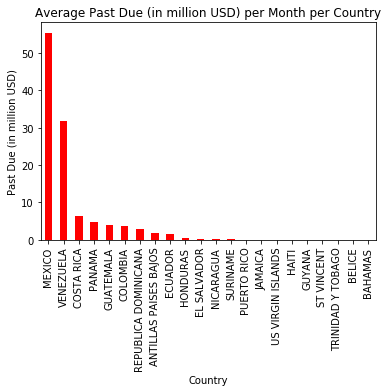

In [4]:
# Calculate average Past Due in million USD per month per country
country_count = extended_dataset_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count = country_count.sort_values(ascending=False)
country_count.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country")
plt.show()

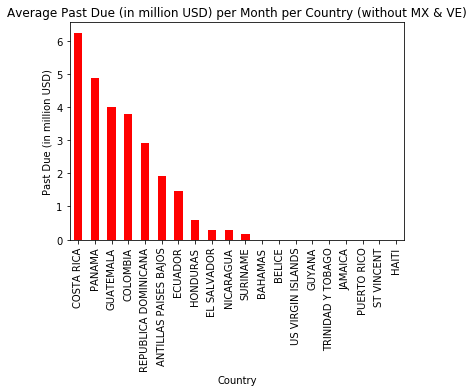

In [5]:
# Get dataset without Mexico and Venezuela
ext_dat_nomx_df = extended_dataset_df.loc[(extended_dataset_df["Country"] != 'MEXICO')].dropna()
ext_dat_nomx_df = ext_dat_nomx_df.loc[(ext_dat_nomx_df["Country"] != 'VENEZUELA')].dropna()

# Calculate average Past Due in USD per month per country
country_count2 = ext_dat_nomx_df.groupby(["Country"])["Past Due AVG MLN"].sum()
country_count2 = country_count2.sort_values(ascending=False)
country_count2.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country (without MX & VE)")
plt.show()                                        
                                          

In [6]:
def year_overview(yearyear):
    year_df = extended_dataset_df.loc[(extended_dataset_df["Year"] == yearyear)].dropna()
    # Group by customer
    customer_gbdf = year_df.groupby(['CCAN'])
    #customer_gbdf = extended_dataset_df.groupby(['CCAN'])

    #customer_gbdf = customer_gbdf[['CCAN', 'Net Investment AVG MLN']]

    # Past Due Count
    cust_pd_count = customer_gbdf['Net Investment AVG YEAR MLN'].sum()
    cust_country = customer_gbdf['Country'].unique().str[0]

    #summary table
    sum_cust_pd_df = pd.DataFrame({
            "Net Investment AVG MLN":cust_pd_count,
            "Country":cust_country})
    sum_cust_pd_df.index.name="CCAN"

    sum_cust_pd_df = sum_cust_pd_df.reset_index()
    # Filter top four countries out of DF
    sum_cust_pd_df = sum_cust_pd_df.loc[((sum_cust_pd_df["Country"] == 'MEXICO') | (sum_cust_pd_df["Country"] == 'VENEZUELA')
                                         | (sum_cust_pd_df["Country"] == 'COSTA RICA') | (sum_cust_pd_df["Country"] == 'PANAMA')
                                        )].dropna()


    # get dataframe sorted by life Expectancy in each continent 
    top_net_inv = sum_cust_pd_df.groupby(["Country"]).apply(lambda x: x.sort_values(["Net Investment AVG MLN"], ascending = False)).reset_index(drop=True)
    # select top N rows within each continent
    n_clients = 2
    top_net_inv = top_net_inv.groupby('Country').head(n_clients)
    #number = year
    
    objects = top_net_inv['CCAN']
    x_value = np.arange(len(objects))
    performance = top_net_inv['Net Investment AVG MLN']

    # plot bar
    plt.bar(x_value, performance, align='center', color=('#FFC30F', '#FFC30F', '#FF5733', '#FF5733', 
                                                         '#c70039', '#c70039', '#581845', '#581845'))
    plt.xticks(x_value, objects)

    col1 = mpatches.Patch(color='#FFC30F', label='Costa Rica')
    col2 = mpatches.Patch(color='#FF5733', label='Mexico')
    col3 = mpatches.Patch(color='#c70039', label='Panama')
    col4 = mpatches.Patch(color='#581845', label='Venezuela')

    plt.legend(handles=[col1, col2, col3, col4])
    plt.xlabel('CCAN')
    plt.ylabel('Net Investment per month (in million USD)')
    plt.title('Top 2 clients in Net Inv Avg (mln USD) per top 4 country in ' + str(yearyear))

    return plt.show(), print(top_net_inv)
    

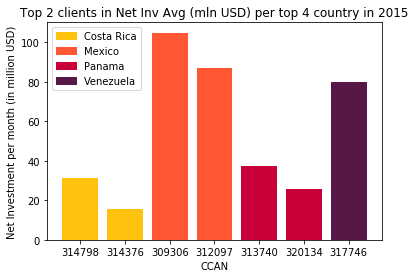

        CCAN  Net Investment AVG MLN     Country
0     314798                   31.49  COSTA RICA
1     314376                   15.36  COSTA RICA
190   309306                  104.88      MEXICO
191   312097                   86.88      MEXICO
1412  313740                   37.35      PANAMA
1413  320134                   25.77      PANAMA
1665  317746                   79.92   VENEZUELA


(None, None)

In [7]:
year_overview(2015)


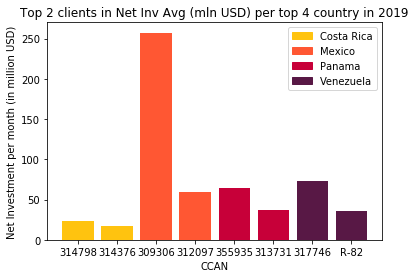

        CCAN  Net Investment AVG MLN     Country
0     314798                   23.86  COSTA RICA
1     314376                   17.54  COSTA RICA
260   309306                  257.28      MEXICO
261   312097                   58.77      MEXICO
1283  355935                   64.65      PANAMA
1284  313731                   37.08      PANAMA
1558  317746                   73.32   VENEZUELA
1559    R-82                   35.73   VENEZUELA


(None, None)

In [8]:
year_overview(2019)

In [9]:
path1 = "datasets/output/exchange_rates.csv"
exchange_rates_df = pd.read_csv(path1)
exchange_rates_df

,Unnamed: 0,Date,Exhange Rate
0,0,2012-01-31,12.980045
1,1,2012-02-28,12.840447
2,2,2012-03-31,12.710813
3,3,2012-04-30,12.993272
4,4,2012-05-31,14.241763
...,...,...,...
99,99,2020-04-30,24.230800
100,100,2020-05-31,22.185207
101,101,2020-06-30,23.019400
102,102,2020-07-31,22.283049


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          212.32    1475.27       0.143919
2014-05-31           74.57    1586.63       0.046999
2014-06-30           94.45    1525.45       0.061916
2014-07-31           86.18    1597.91       0.053933
2014-08-31          105.76    1535.10       0.068895
...                    ...        ...            ...
2020-03-31          144.86    1144.26       0.126597
2020-04-30          148.14    1136.23       0.130379
2020-05-31          163.84    1159.34       0.141322
2020-06-30          158.56    1183.65       0.133959
2020-07-31          150.98    1166.09       0.129475

[76 rows x 3 columns]


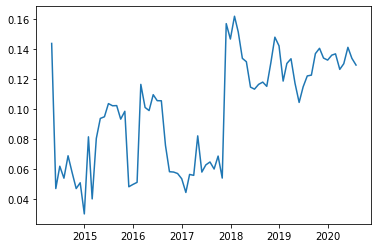

In [10]:
new_extended_dataset_df = extended_dataset_df.groupby(['DATE'])
#print(new_extended_dataset_df)
sum_past_due = new_extended_dataset_df['Past Due MLN'].sum()
total_net = new_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index = pd.DataFrame({
    "Total Past Due": sum_past_due,
    "Total Net": total_net,
    "Past Due Rate": sum_past_due / total_net
    
})
print(past_due_index )

y = past_due_index['Past Due Rate']
x = past_due_index.index
plt.plot(x,y)


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          156.46    1475.27       0.106055
2014-05-31           41.35    1586.63       0.026062
2014-06-30           67.29    1525.45       0.044112
2014-07-31           41.83    1597.91       0.026178
2014-08-31           53.35    1535.10       0.034753
...                    ...        ...            ...
2020-03-31           34.29    1144.26       0.029967
2020-04-30           31.93    1136.23       0.028102
2020-05-31           37.25    1159.34       0.032130
2020-06-30           33.37    1183.65       0.028192
2020-07-31           29.85    1166.09       0.025598

[76 rows x 3 columns]


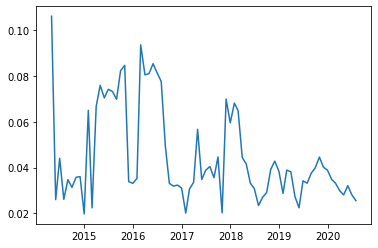

In [15]:
mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])

#print(new_extended_dataset_df)
sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": sum_past_due_mx / total_net_mx
    
})
print(past_due_index_mx )

y = past_due_index_mx['Past Due Rate']
x = past_due_index_mx.index
plt.plot(x,y)

### Past Due Rate vs. USD to MXN Exchange Rate

In [11]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_df = past_due_index
exc_pastdue_df.reset_index(level=0, inplace=True)
exc_pastdue_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].astype(str)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].str[:-3]

exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,212.32,1475.27,0.143919
1,2014-05,74.57,1586.63,0.046999
2,2014-06,94.45,1525.45,0.061916
3,2014-07,86.18,1597.91,0.053933
4,2014-08,105.76,1535.10,0.068895


In [12]:
# Getting Exchange Rate data
exchange_rate_path = "datasets/output/exchange_rates.csv"
exchange_rate_df = pd.read_csv(exchange_rate_path)
del exchange_rate_df['Unnamed: 0']
exchange_rate_df['Date'] = exchange_rate_df['Date'].str[:-3]
exchange_rate_df.head()

,Date,Exhange Rate
0,2012-01,12.980045
1,2012-02,12.840447
2,2012-03,12.710813
3,2012-04,12.993272
4,2012-05,14.241763


In [13]:
# Merge both DataFrames
exc_pastdue_df = exc_pastdue_df.merge(exchange_rate_df)
exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,Exhange Rate
0,2014-04,212.32,1475.27,0.143919,13.08806
1,2014-05,74.57,1586.63,0.046999,12.85641
2,2014-06,94.45,1525.45,0.061916,12.97124
3,2014-07,86.18,1597.91,0.053933,13.19951
4,2014-08,105.76,1535.10,0.068895,13.07460


The r-squared is: 0.21536568886207363


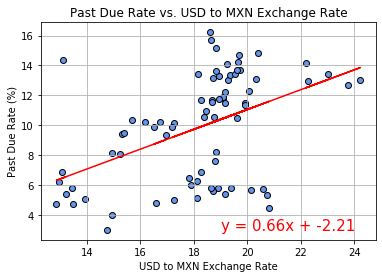

In [14]:
# Scatter plot
x_values = exc_pastdue_df['Exhange Rate']
y_values = exc_pastdue_df['Past Due Rate'] * 100

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to MXN Exchange Rate for Mexico

In [18]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_mx_df = past_due_index_mx
exc_pastdue_mx_df.reset_index(level=0, inplace=True)
exc_pastdue_mx_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].astype(str)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].str[:-3]

exc_pastdue_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,156.46,1475.27,0.106055
1,2014-05,41.35,1586.63,0.026062
2,2014-06,67.29,1525.45,0.044112
3,2014-07,41.83,1597.91,0.026178
4,2014-08,53.35,1535.10,0.034753


In [19]:
# Merge both DataFrames
exc_pastdue_mx_df = exc_pastdue_mx_df.merge(exchange_rate_df)
exc_pastdue_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,Exhange Rate
0,2014-04,156.46,1475.27,0.106055,13.08806
1,2014-05,41.35,1586.63,0.026062,12.85641
2,2014-06,67.29,1525.45,0.044112,12.97124
3,2014-07,41.83,1597.91,0.026178,13.19951
4,2014-08,53.35,1535.10,0.034753,13.07460


The r-squared is: 0.08406676559808876


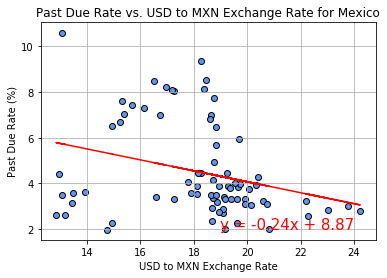

In [20]:
# Scatter plot
x_values = exc_pastdue_mx_df['Exhange Rate']
y_values = exc_pastdue_mx_df['Past Due Rate'] * 100

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate for Mexico')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()